# Figure Tuning curve Gratings
On a 5 blocs de 96 patrons, ou chaque patron est une combinaison de 12 angles et 8 niveaux de bruits. 

Donc quand on mesure les tunings curve à la fin, il faut les diviser par 5 quand c'est une tuning curve en fonction du bruit, ou par 5+8 quand c'est un niveau total.

C'est une copie du notebook des PSTH, avec les TC plus jolis

# Extracting photodiode data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import KwikTools as kt
from tqdm import tqdm
import csv

In [2]:
subfolder = 'E007_a17//'

In [3]:
dataset = kt.load(subfolder+'/experiment1_100.raw.kwd',
                  'all')

info = dataset['info']['0']
data = dataset['data']['0']
channels = dataset['channel_bit_volts']['0']
timestamps = dataset['timestamps']['0']

In [4]:
print('Timestamps shape', timestamps.shape)
print('Timestamps range from %s to %s' % (timestamps.min(), timestamps.max()))
print('Which should be %s seconds' % (timestamps.max() - timestamps.min()))

Timestamps shape (30502500,)
Timestamps range from 6888.49 to 7905.239966666667
Which should be 1016.7499666666672 seconds


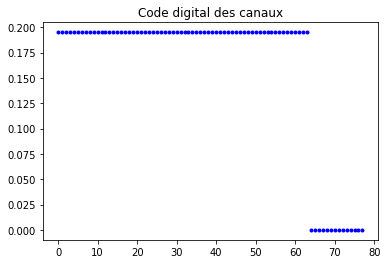

In [5]:
plt.plot(channels, '.b')
plt.title('Code digital des canaux')
plt.show()
plt.close('all')

plt.figure(figsize=(10, 6))
plt.plot(data[:,35][::10], linewidth=1)
plt.title("Photodiode signal, zoom on a peak, get the amplitude and the inter peak and multiply by 100")
plt.show()

plt.plot(data[:,70][::10])
plt.pause(.1)
plt.close('all')

In [6]:
photodiode_channel = data[:, 70]
del data

KeyboardInterrupt: 

In [ ]:
# https://stackoverflow.com/questions/15800895/finding-clusters-of-numbers-in-a-list
def grouper(iterable, timeframe):
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= timeframe:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group


above_threshold = np.where(photodiode_channel > 1100)[0]
chunk_list = list(enumerate(grouper(above_threshold, 600), 1))
print('Found %s chunks' % len(chunk_list))

In [ ]:
chunk_beg_list = []
chunk_end_list = []
min_timestamps = timestamps.min()

for chunk in chunk_list:
    chunk_beg_list.append(chunk[1][0])  # /30000+min_timestamps)
    chunk_end_list.append(chunk[1][-1])  # /30000+min_timestamps)

plt.figure(figsize=(12, 6))
plt.plot(photodiode_channel[:9000000])
plt.plot(chunk_beg_list[:65], np.full_like(chunk_beg_list[:65], 1100), '.r',
         label='Sequences begs')
plt.plot(chunk_end_list[:65], np.full_like(chunk_end_list[:65], 1100), '.y',
         label='Sequences ends')
plt.legend()
#plt.xlim(100000/2, 380000/2)
plt.xlim(-50000, 300000)
plt.title("We're losing the very first trace using chunk ends, but at least there is no init artifact")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.linspace(len(photodiode_channel)-900000, len(photodiode_channel), 900000),
         photodiode_channel[-900000:])
plt.plot(chunk_beg_list[-25:], np.full_like(chunk_beg_list[-25:], 1100), '.r',
         label='Sequences begs')
plt.plot(chunk_end_list[-25:], np.full_like(chunk_end_list[-25:], 1100), '.y',
         label='Sequences ends')
plt.legend()
plt.xlim(len(photodiode_channel)-200000, len(photodiode_channel)+50000)
plt.title("Same thing but for the end. The dip is the end of stim, and then the white from JupNotebook\n the last\
          end to end sequence has to be deleted")
plt.show()

plt.close('all')

# rerunning the chunk lists with sample rate converted to actual time
chunk_beg_list = []
chunk_end_list = []
for chunk in chunk_list:
    chunk_beg_list.append(chunk[1][0]/30000+min_timestamps)
    chunk_end_list.append(chunk[1][-1]/30000+min_timestamps)

# we remove the un-needed last sequence
del chunk_end_list[-1]
del chunk_beg_list[-1]

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.asarray(chunk_end_list[1:]) - np.asarray(chunk_end_list[:-1]))
plt.title('Stimulus presentation time\n We have very little deviation between each presentation, at most a few ms')
plt.xlabel('Trial no')
plt.ylabel('Presentation duration')
plt.show()

# Extracting spike times from clusters 

In [ ]:
spike_times = np.load(subfolder+'spike_times.npy')
spike_clusters = np.load(subfolder+'spike_clusters.npy')

# group spike with cluster identity
spike_cluster_table = []
for i, spike in enumerate(spike_times):
    spike_cluster_table.append((spike[0], spike_clusters[i]))

# extract cluster metadata
cluster_groups = []
with open(subfolder+'./cluster_groups.csv', 'r') as csvFile:
    reader = csv.reader(csvFile)
    for row in reader:
        if row[0].split('\t')[1] == 'good':
            cluster_groups.append(int(row[0].split('\t')[0]))

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(*zip(*spike_cluster_table), s=1)
plt.xlabel('Time (in sample not seconds)')
plt.ylabel('Cluster')
plt.title('Spiking times for each cluster')
plt.show()

In [ ]:
good_spikes = []

for good_cluster in cluster_groups:
    temp_lst = []
    for spike_cluster in spike_cluster_table:
        if spike_cluster[-1] == good_cluster:
            temp_lst.append(spike_cluster[0]/30000+min_timestamps)

    good_spikes.append(temp_lst)

In [ ]:
hist_list = []
for it, cluster in enumerate(good_spikes):
    plt.figure(figsize=(4, 4))
    hist = plt.hist(cluster, bins=chunk_end_list)
    hist_list.append(hist[0])
    plt.xlabel('Time (s)')
    plt.ylabel('Spikes')
    plt.title('Spikes binned (matplotlib) per sequences for neuron cluster #%s' % it)
    plt.show()
    plt.pause(.1)

plt.close('all')

In [ ]:
plt.figure(figsize=(12, 8))
cluster_spike_bins = []
for cluster in good_spikes:
    spike_bins = []

    for i in range(len(chunk_end_list)-1):
        where = np.where(
            (cluster >= chunk_beg_list[i]) & (cluster <= chunk_end_list[i]-.5))[0]
        spike_bins.append(len(where))

    plt.ylabel('Spikes')
    plt.xlabel('Sequence #')
    plt.title('Spiked bin (custom)')
    plt.plot(spike_bins)
    cluster_spike_bins.append(spike_bins)

In [ ]:
plt.close('all')

# Linking the results with the stimulation
For the gratings I don't have a stim file but I saved and controlled the code for each sequence, so I can re-generate it

In [ ]:
import itertools

# Orientations
N_thetas = 12
# we offset by pi/2 to prevent problems with matplotlib's displays and psychopy
thetas = np.linspace(0, np.pi, N_thetas)

# Noise
B_thetas = np.linspace(np.pi/2, np.pi/32, 8)/2.5
B_thetas = np.linspace(20, 5, 8)
# Presentation of each pattern
stim_duration = .02  # s

# Repetition of each block
repetition = 5

rng = np.random.RandomState(42)
sequence = list(itertools.product(thetas, B_thetas))

plt.scatter(*zip(*sequence))
plt.title('Each dot is a stimulus')
plt.xlabel('theta(pi)')
plt.ylabel('SF ()')
plt.show()

In [ ]:
sorted_by_btheta = sorted(sequence, key=lambda tup: tup[1], reverse=True)
sorted_by_btheta
sequence = sorted_by_btheta

In [ ]:
full_sequences = sequence.copy()
for rep in range(repetition-1):
    full_sequences += sequence

In [ ]:
len(full_sequences) == len(chunk_end_list)

In [ ]:
len(cluster_spike_bins[0])

In [ ]:
# n sequences is n-1 bins
(len(sequence)*5)-1 == len(cluster_spike_bins[0])

In [ ]:
seq_FR_list = []
for it, cluster in enumerate(cluster_spike_bins):
    # print(it) #cluster number
    temp_list = []  # list of sequence info with firing rate
    for it2, sequence in enumerate(full_sequences):
        # print(it2) #sequence number
        i = it2-1
        FR = cluster[i] / (chunk_end_list[i] - chunk_beg_list[i])
        temp_list.append((sequence, FR))

    seq_FR_list.append(temp_list)

In [ ]:
all_unique_tuple_FR_list = []

for cluster in seq_FR_list:
    uniqs = np.unique(np.asarray(cluster)[:, 0])
    # first element is sequence info (theta,cpd) and second is FR summed on 5 repetitions
    unique_tuple_FR_list = []
    for unique_tuple in uniqs:
        sum_list = []
        for seq_fr in cluster:
            if seq_fr[0] == unique_tuple:
                sum_list.append(seq_fr[1])
        seq_sum = np.sum(sum_list)
        unique_tuple_FR_list.append((unique_tuple, seq_sum))

    all_unique_tuple_FR_list.append(unique_tuple_FR_list)

In [ ]:
uniq_theta = thetas.copy()
uniq_b_theta = B_thetas.copy()

In [ ]:
all_unique_tuple_FR_list[0]

# Global tuning curve (taking in account all noise levels)

In [ ]:
from lmfit import Model, Parameters


def tuning_function(x, j, B, fmax):  # von mises, baseline is the minimum neuron activity
    N = len(x)
    if B == np.inf:
        VM = np.ones_like(x)
    else:
        VM = np.exp((np.cos(2.*np.pi*(x-j)/N)-1.)/4/(B*np.pi/180)**2)
    #VM /= VM.sum(axis=0)
    return fmax * VM


def fit_plot(array, datacol='.b', fitcol='k', data_kws=None, do_title=True,
             seq_nbr=None):

    # fit the gaussian
    x = np.linspace(0, len(array), len(array))
    y = array
    N = len(array)

    #mod = GaussianModel()

    mod = Model(tuning_function)
    pars = Parameters()
    y = y-np.min(y)
    pars.add_many(('j', y.argmax(), True,  0.0, N), ('B', 15., True,  0.1, 360),
                  ('fmax', y.max(), True,  0.0, 100.))

    #pars = mod.guess(y, x=x)
    #pars['center'] = lmfit.Parameter('center', seq_nbr*15)
    out = mod.fit(y, pars, x=x, nan_policy='omit')
    # print(out.fit_report(min_correl=0.25))

    '''# plot the fits
    out.plot_fit(datafmt=datacol, fitfmt=fitcol,
                 data_kws=data_kws, show_init=False)'''
    # print(out.fit_report())
    sigma = out.best_values['B']

    '''    
    if do_title:
        ax.set_title('Sequence #%s -- ' % seq_nbr + r'$B_\theta$ = %.2f' % sigma)'''
    return out.best_values, (1-out.residual.var() / np.var(y))

In [ ]:
# we can sum along theta, which is likely to be uninformative due to noise in certains patterns

for it, neuron in enumerate(all_unique_tuple_FR_list):
    FR_sum = []
    FR_ind = []
    for thetas in uniq_theta:
        theta_sum_list = []
        for tup_fr in neuron:
            if tup_fr[0][0] == thetas:
                theta_sum_list.append(tup_fr[1])

        FR_sum.append(np.sum(theta_sum_list))
        FR_ind.append(theta_sum_list)
    xs = np.linspace(0, len(FR_sum), len(FR_sum))
    fig = plt.figure(figsize=(10, 7.5))
    ax = plt.subplot(111)

    best_vals = fit_plot(np.asarray(FR_sum)/(5+8))[0]
    fit_report = fit_plot(np.asarray(FR_sum)/(5+8))[1]


    for it3, theta in enumerate(FR_ind):
        ax.errorbar(xs[it3],
                    np.sum(FR_ind[it3])/(5+8),
                    np.std(FR_ind[it3])/(5+8), fmt='o', capsize=3,
                    c='k', alpha=.7)
    #ax.plot(xs, np.asarray(FR_sum)/(5+8), '.b')
    
    ax.plot(xs,
        tuning_function(x=xs,
                        j=best_vals['j'], fmax=best_vals['fmax'],
                        B=best_vals['B'])+(np.asarray(FR_sum)/(5+8)).min(),
        c='k')

    ax.set_ylabel('Fréquence de décharge (Hz)', fontsize=14)
    ax.set_xlabel('Angle (°)', fontsize=14)
    ax.set_title('Ouverture à mi-hauteur : ' + r'$B_\theta$ = %.2f°  ' %
                 best_vals['B'], fontsize=16)
    plt.suptitle('(r² = %.2f)' % fit_report, fontsize=14, y=.88)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = np.linspace(0, np.pi, len(labels))*180/np.pi

    ax.set_xticklabels(labels)

    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.savefig('./TC_global/Global_TC_pen%s_N%s.svg' % (subfolder.split('/')[0], it),
                format='svg', transparent=True, bbox_inches='tight')
    plt.show()
    plt.close('all')

# Angle and noise dissociated (so 8 tuning curves per neuron)

In [ ]:
neuron_to_plot = 1

all_btheta_list = []
for btheta in uniq_b_theta:
    theta_fr_perBtheta = []
    for theta in uniq_theta:
        for tup_theta_btheta in seq_FR_list[neuron_to_plot]:
            if tup_theta_btheta[0][0] == theta and tup_theta_btheta[0][1] == btheta:
                theta_fr_perBtheta.append(tup_theta_btheta)

    all_btheta_list.append(theta_fr_perBtheta)


for b_theta_curve in all_btheta_list:
    b_theta_points = []
    for theta in uniq_theta:
        theta_lst = []
        for tup in b_theta_curve:
            if tup[0][0] == theta:
                theta_lst.append(tup[1])
        b_theta_points.append(theta_lst)

    fig = plt.figure(figsize=(10, 7.5))
    ax = plt.subplot(111)

    xs = np.linspace(0, len(b_theta_points), len(b_theta_points))
    FR_sum = np.sum(np.asarray(b_theta_points), axis=1)

    best_vals = fit_plot(np.asarray(FR_sum))[0]
    fit_report = fit_plot(np.asarray(FR_sum))[1]

    ax.plot(xs,
            tuning_function(x=xs,
                            j=best_vals['j'], fmax=best_vals['fmax'],
                            B=best_vals['B'])+(np.asarray(FR_sum)/(5)).min(),
            c='k')

    ax.errorbar(xs,
                FR_sum,
                np.std(b_theta_points, axis=1), fmt='o', capsize=3,
                 c='k', alpha=.8)

    ax.set_ylabel('Fréquence de décharge (Hz)', fontsize=14)
    ax.set_xlabel('Angle (°)', fontsize=14)
    ax.set_title('CPD stim. = %.1f  ;  ' % b_theta_curve[0][0][1] + r'$B_\theta$ = %.2f°' %
                 best_vals['B'], fontsize=16)
    plt.suptitle('(r² = %.2f)' % fit_report, fontsize=14, y=.88)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = np.linspace(0, np.pi, len(labels))*180/np.pi

    ax.set_xticklabels(labels)

    ax.tick_params(axis='both', which='major', labelsize=12)
    fig.savefig('./TC_Btheta/N%s_B_theta_TC_pen%s_CPD%.2f.svg' % (neuron_to_plot, subfolder.split('/')[0], b_theta_curve[0][0][1]),
                format='svg', transparent=True, bbox_inches='tight')
   
    plt.show()
    plt.close('all')
